# Neurobubbles Regressions

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.    Initial Processing

In [19]:
# importing data
data = pd.read_csv('/Users/cadyngo/Desktop/flattened_data_w_bio.csv')
data['market_id'] = data.groupby('session').ngroup()
unique_sessions = data['session'].unique()
# print(unique_sessions)
print(f'Total markets: {len(unique_sessions)}')

# calculating moving averages and leading values
data['dose_r_ma3'] = data['pl_dose_r'].rolling(window=3, min_periods=1).mean()
data['dose_r_ma5'] = data['pl_dose_r'].rolling(window=5, min_periods=1).mean()
data['dose_mu_ma3'] = data['pl_dose_mu'].rolling(window=3, min_periods=1).mean()
data['dose_mu_ma5'] = data['pl_dose_mu'].rolling(window=5, min_periods=1).mean()
data['log_returns_lead5'] = data['pct_returns'].shift(-5)

# forecast data shifting
def shift_forecast(forecast, shift, length):
    shifted = [np.nan] * shift + list(forecast)
    # check that the length matches the DF's length
    if len(shifted) > length:
        return shifted[:length]
    else:
        return shifted + [np.nan] * (length - len(shifted))

# forecast columns    
data['forecast_f0'] = data['pl_f0']
data['forecast_f1'] = shift_forecast(data['pl_f1'], 2, len(data))
data['forecast_f2'] = shift_forecast(data['pl_f2'], 5, len(data))
data['forecast_f3'] = shift_forecast(data['pl_f3'], 10, len(data))

# check that the length of the forecast columns match the length of the DF
print(f"Original length: {len(data)}")
print(f"Length of forecast_f0: {len(data['forecast_f0'])}")
print(f"Length of forecast_f1: {len(data['forecast_f1'])}")
print(f"Length of forecast_f2: {len(data['forecast_f2'])}")
print(f"Length of forecast_f3: {len(data['forecast_f3'])}")

# deviation from forecast
data['deviation_f0'] = data['price'] - data['forecast_f0']
data['deviation_f1'] = data['price'] - data['forecast_f1']
data['deviation_f2'] = data['price'] - data['forecast_f2']
data['deviation_f3'] = data['price'] - data['forecast_f3']

# percentage change in deviation
data['pct_change_deviation_f0'] = np.where(data['forecast_f0'] != 0, (data['deviation_f0'] / data['forecast_f0']) * 100, np.nan)
data['pct_change_deviation_f1'] = np.where(data['forecast_f1'] != 0, (data['deviation_f1'] / data['forecast_f1']) * 100, np.nan)
data['pct_change_deviation_f2'] = np.where(data['forecast_f2'] != 0, (data['deviation_f2'] / data['forecast_f2']) * 100, np.nan)
data['pct_change_deviation_f3'] = np.where(data['forecast_f3'] != 0, (data['deviation_f3'] / data['forecast_f3']) * 100, np.nan)

Total markets: 19
Original length: 9114
Length of forecast_f0: 9114
Length of forecast_f1: 9114
Length of forecast_f2: 9114
Length of forecast_f3: 9114


## 2. Market Prices


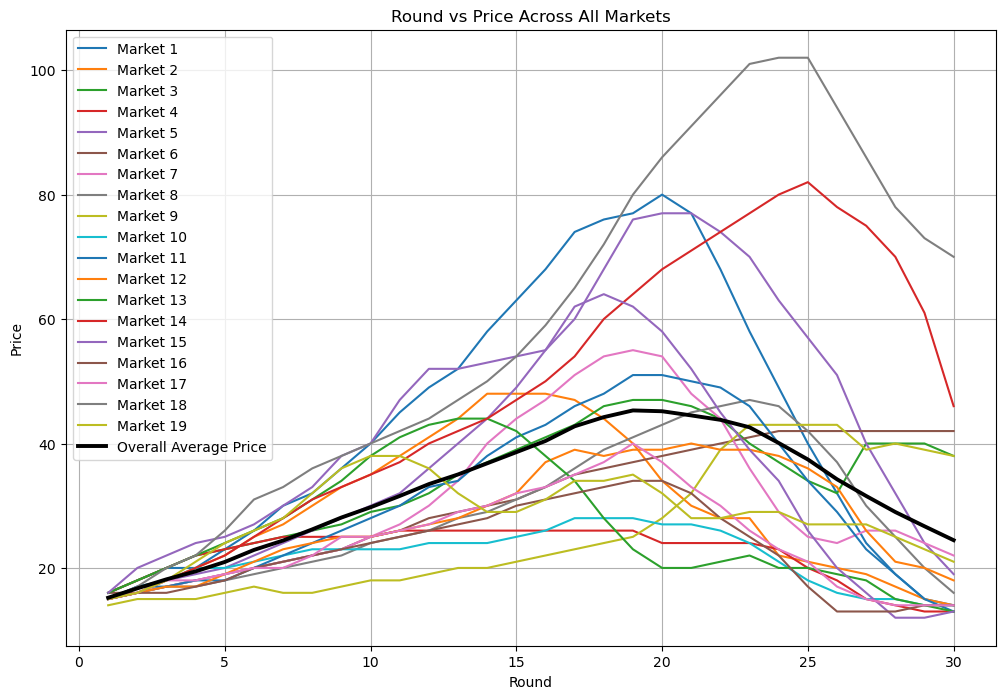

In [41]:
# extract unique market prices
market_prices = data[['market_id', 'round', 'price']].drop_duplicates().sort_values(['market_id', 'round'])

# calculate overall average price across markets for each period
overall_avg_price = data.groupby('round').agg(overall_average_price=('price', 'mean')).reset_index()

# plot market prices vs overall average price
plt.figure(figsize=(12, 8))
sorted_market_ids = sorted(data['market_id'].unique())

# each market's prices
for market in sorted_market_ids:
    avg_price_market = market_prices[market_prices['market_id'] == market]
    plt.plot(avg_price_market['round'], avg_price_market['price'], label=f'Market {market + 1}')

# overall average price
plt.plot(overall_avg_price['round'], overall_avg_price['overall_average_price'], color='black', linewidth=2.8, label='Overall Average Price')

# plot
plt.xlabel('Round')
plt.ylabel('Price')
plt.title('Round vs Price Across All Markets')
handles, labels = plt.gca().get_legend_handles_labels()
sorted_legend = sorted(zip(labels, handles), key=lambda x: int(x[0].split()[-1]) if x[0] != 'Overall Average Price' else float('inf'))
labels, handles = zip(*sorted_legend)
plt.legend(handles, labels)
plt.grid(True)
plt.show()

## 3. Volumes
i.e. number of rows

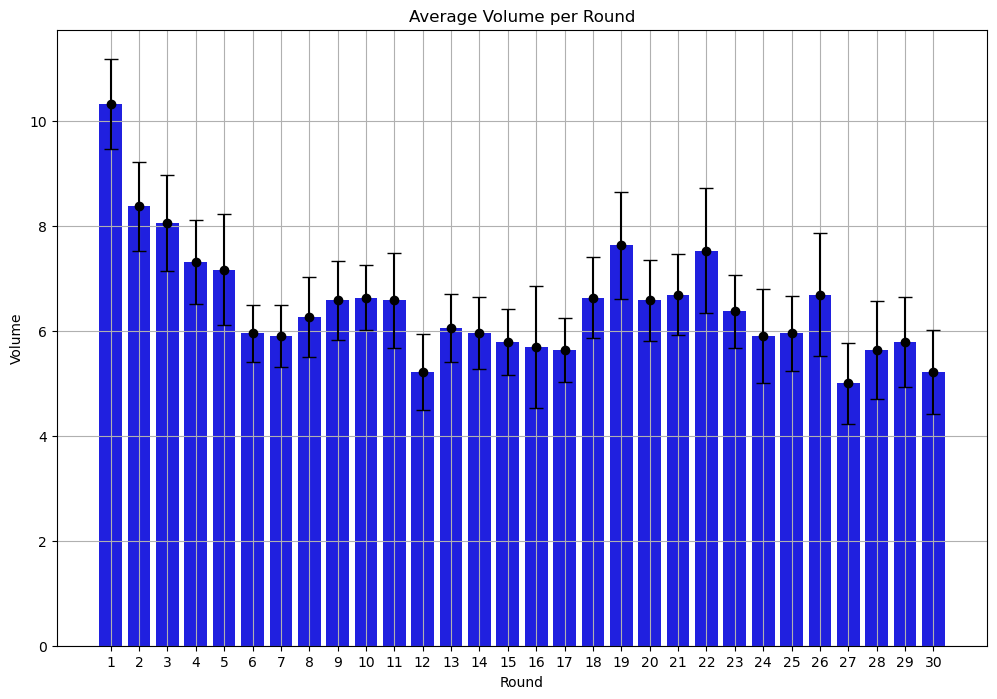

In [36]:
# extract unique market volumes
market_volumes = data[['market_id', 'round', 'volume']].drop_duplicates().sort_values(['market_id', 'round'])

# standard error of volume per period across markets
market_volumes_se = market_volumes.groupby('round').agg(
    average_volume=('volume', 'mean'),
    se_volume=('volume', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# plot average volume per round with error bars
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='round', y='average_volume', data=market_volumes_se, color='blue', errorbar=None)
bar_positions = [bar.get_x() + bar.get_width() / 2 for bar in ax.patches]
ax.errorbar(x=bar_positions, y=market_volumes_se['average_volume'], 
            yerr=market_volumes_se['se_volume'], fmt='o', color='black', capsize=5)
ax.set_xlabel('Round')
ax.set_ylabel('Volume')
ax.set_title('Average Volume per Round')
ax.grid(True)
plt.show()

## 4. Biometric Data
All use tonic.

In [22]:
# average EDA, BVP, HR, Temp across subjects for each market
avg_bio = data.groupby(['market_id', 'round']).agg(
    avg_eda = ('eda_ton_mean', 'mean'),
    avg_bvp = ('bvp_ton_mean', 'mean'),
    avg_hr = ('hr_ton_mean', 'mean'),
    avg_temp = ('temp_ton_mean', 'mean')
).reset_index()

bio_price_merged = pd.merge(avg_bio, market_prices, on=['market_id', 'round'])

### 4.1 EDA vs Price

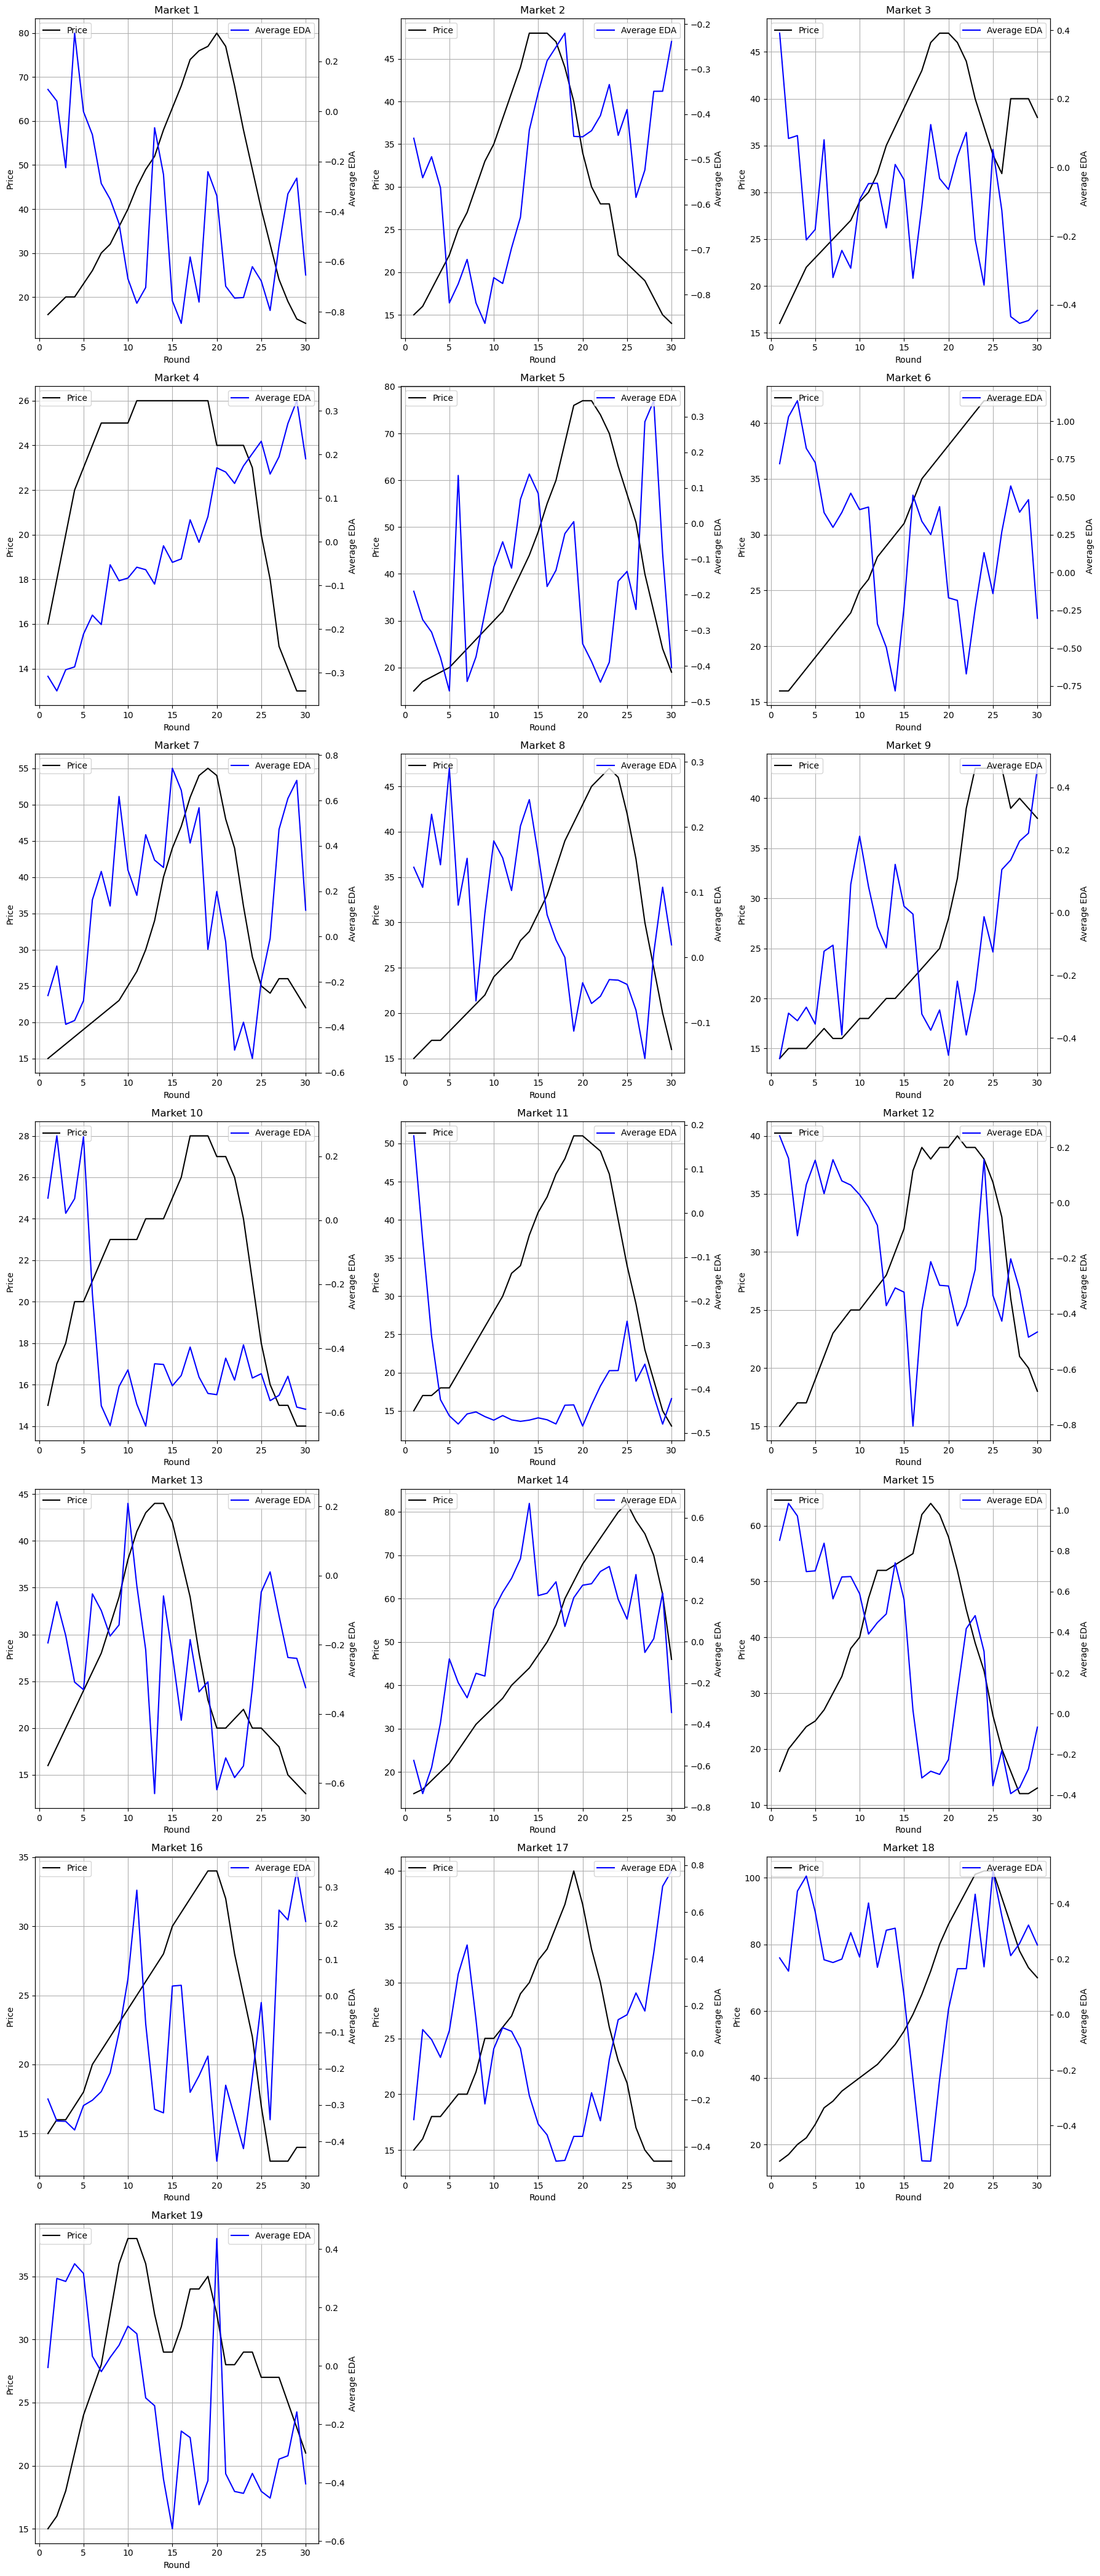

In [23]:
# subplots
sorted_market_ids = sorted(data['market_id'].unique())
num_markets = len(sorted_market_ids)
num_rows = (num_markets + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
axes = axes.flatten()  # flatten to easily iterate over

# plot each market
for i, market in enumerate(sorted_market_ids):
    market_data = avg_bio[avg_bio['market_id'] == market]
    price_data = market_prices[market_prices['market_id'] == market]
    
    ax = axes[i]
    ax.plot(price_data['round'], price_data['price'], color='black', label='Price')
    ax.set_xlabel('Round')
    ax.set_ylabel('Price')
    ax.set_title(f'Market {market + 1}')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(market_data['round'], market_data['avg_eda'], color='blue', label='Average EDA')
    ax2.set_ylabel('Average EDA')
    ax2.legend(loc='upper right')

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

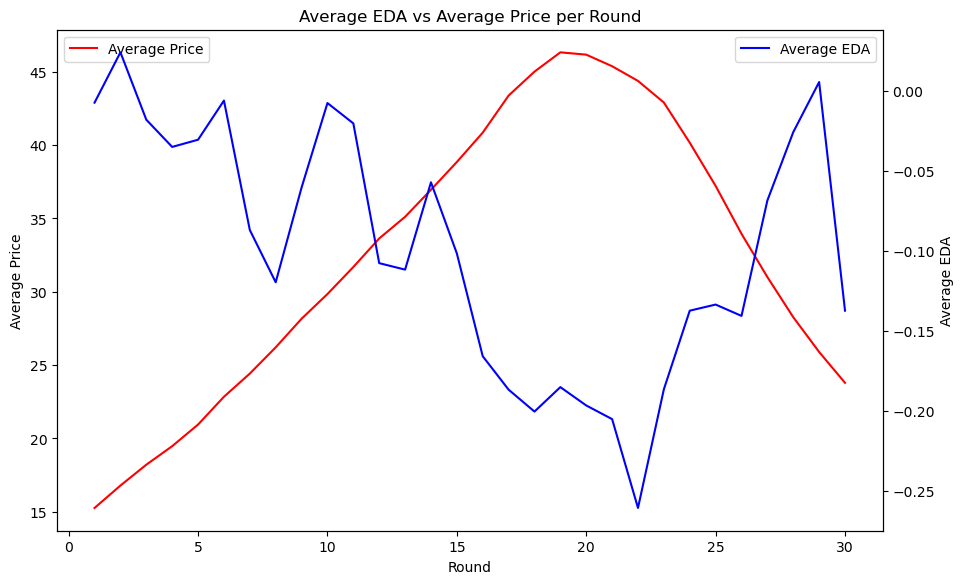

In [39]:
avg_eda_per_round = avg_bio.groupby('round')['avg_eda'].mean().reset_index()
avg_price_per_round = market_prices.groupby('round')['price'].mean().reset_index()
merged_averages = pd.merge(avg_eda_per_round, avg_price_per_round, on='round')

# plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# average price
ax1.set_xlabel('Round')
ax1.set_ylabel('Average Price')
ax1.plot(merged_averages['round'], merged_averages['price'], color='red', label='Average Price')
ax1.tick_params(axis='y')

# average EDA
ax2 = ax1.twinx()
ax2.set_ylabel('Average EDA')
ax2.plot(merged_averages['round'], merged_averages['avg_eda'], color='blue', label='Average EDA')
ax2.tick_params(axis='y')

# legends
fig.tight_layout(pad=2.0)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average EDA vs Average Price per Round')
plt.show()

r = 0.03700921944532009


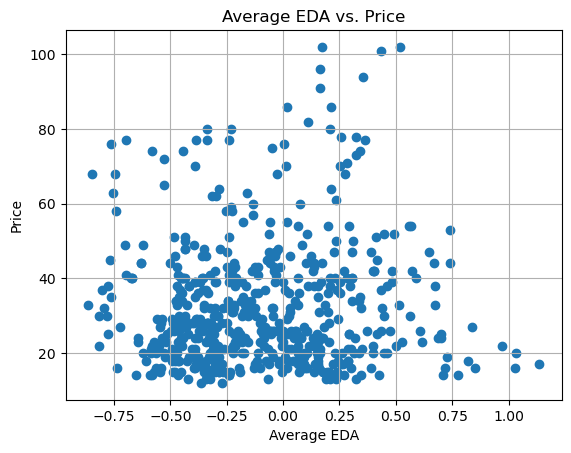

In [25]:
correlation = bio_price_merged['avg_eda'].corr(bio_price_merged['price'])
print(f"r = {correlation}")

x = bio_price_merged['avg_eda']
y = bio_price_merged['price']

plt.scatter(x, y)
plt.xlabel('Average EDA')
plt.ylabel('Price')
plt.title('Average EDA vs. Price')
plt.grid(True)
plt.show()

### 4.2 BVP vs Price

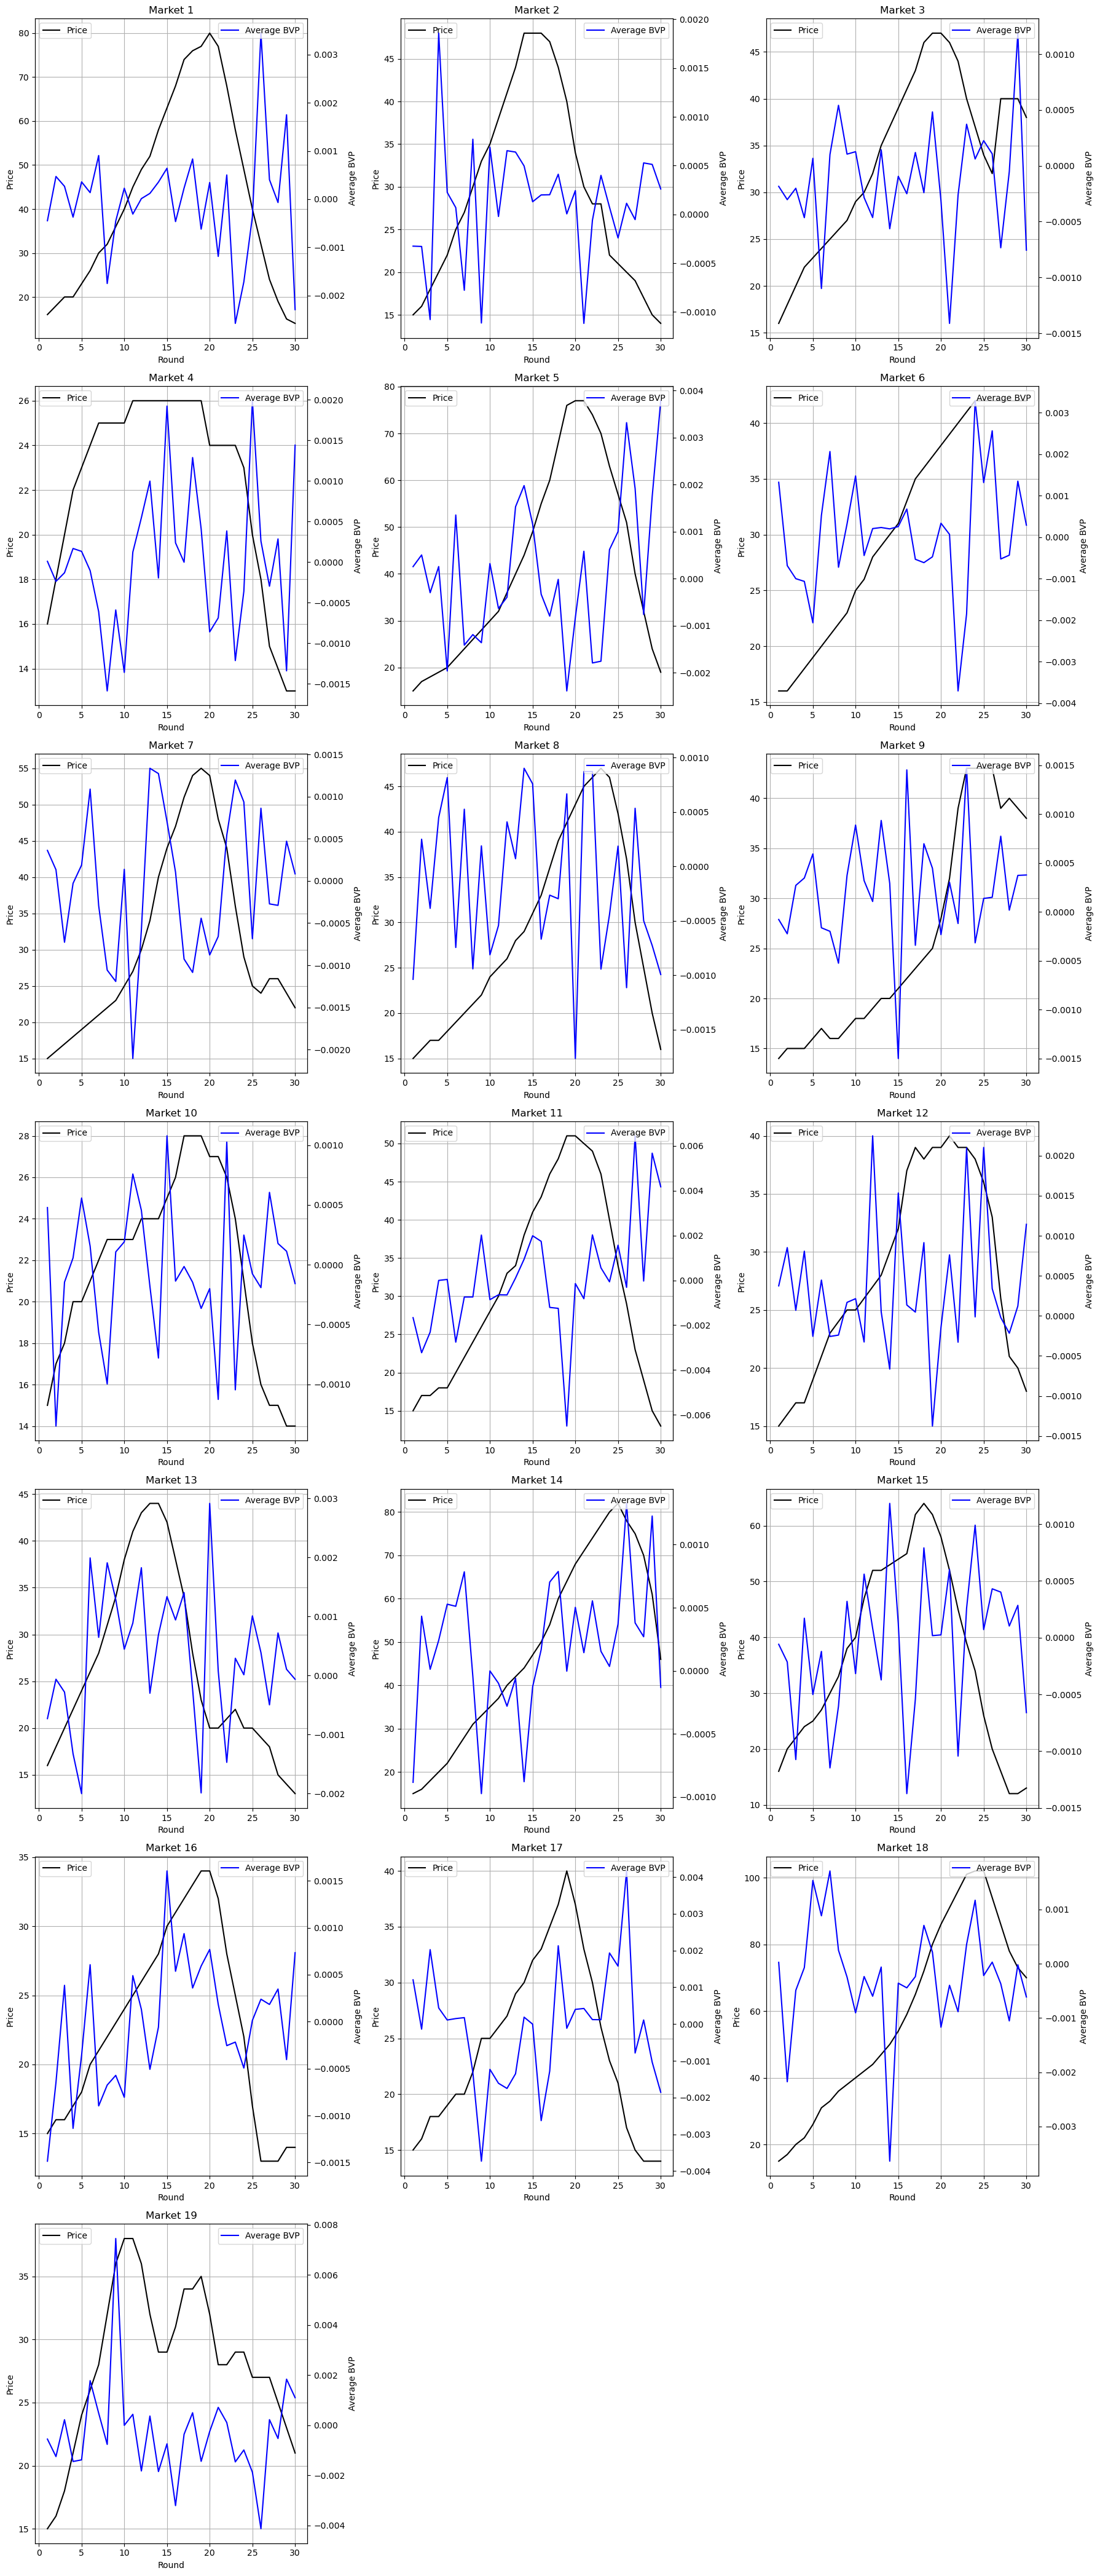

In [26]:
# subplots
sorted_market_ids = sorted(data['market_id'].unique())
num_markets = len(sorted_market_ids)
num_rows = (num_markets + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
axes = axes.flatten()  # flatten to easily iterate over

# plot each market
for i, market in enumerate(sorted_market_ids):
    market_data = avg_bio[avg_bio['market_id'] == market]
    price_data = market_prices[market_prices['market_id'] == market]
    
    ax = axes[i]
    ax.plot(price_data['round'], price_data['price'], color='black', label='Price')
    ax.set_xlabel('Round')
    ax.set_ylabel('Price')
    ax.set_title(f'Market {market + 1}')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(market_data['round'], market_data['avg_bvp'], color='blue', label='Average BVP')
    ax2.set_ylabel('Average BVP')
    ax2.legend(loc='upper right')

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

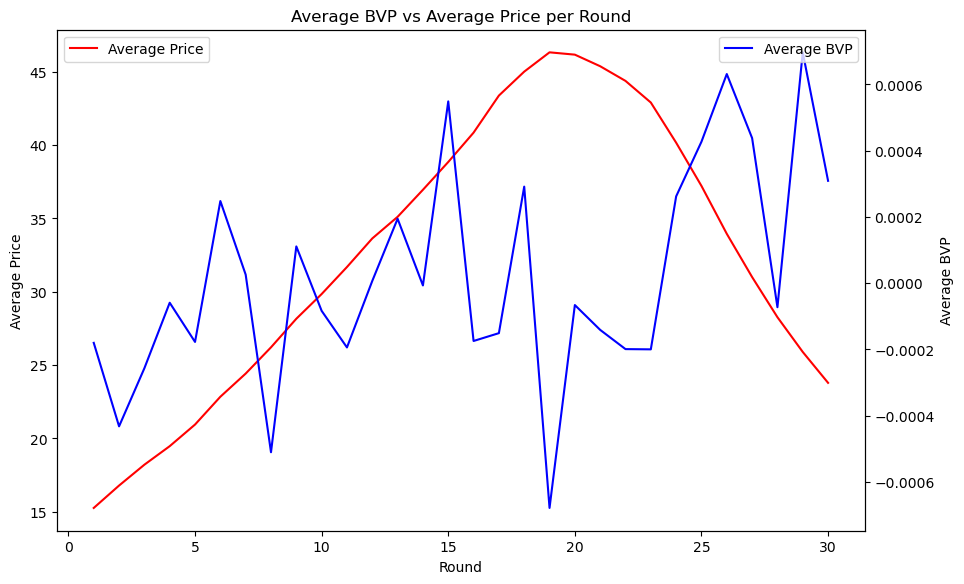

In [27]:
avg_bvp_per_round = avg_bio.groupby('round')['avg_bvp'].mean().reset_index()
avg_price_per_round = market_prices.groupby('round')['price'].mean().reset_index()
merged_averages = pd.merge(avg_bvp_per_round, avg_price_per_round, on='round')

# plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# average price
ax1.set_xlabel('Round')
ax1.set_ylabel('Average Price')
ax1.plot(merged_averages['round'], merged_averages['price'], color='red', label='Average Price')
ax1.tick_params(axis='y')

# average BVP
ax2 = ax1.twinx()
ax2.set_ylabel('Average BVP')
ax2.plot(merged_averages['round'], merged_averages['avg_bvp'], color='blue', label='Average BVP')
ax2.tick_params(axis='y')

# legends
fig.tight_layout(pad=2.0)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average BVP vs Average Price per Round')
plt.show()

r = -0.01655845599174916


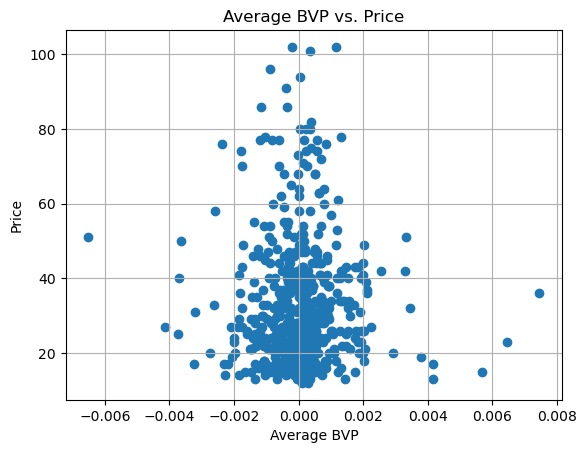

In [28]:
correlation = bio_price_merged['avg_bvp'].corr(bio_price_merged['price'])
print(f"r = {correlation}")

x = bio_price_merged['avg_bvp']
y = bio_price_merged['price']

plt.scatter(x, y)
plt.xlabel('Average BVP')
plt.ylabel('Price')
plt.title('Average BVP vs. Price')
plt.grid(True)
plt.show()

### 4.3 HR vs Price

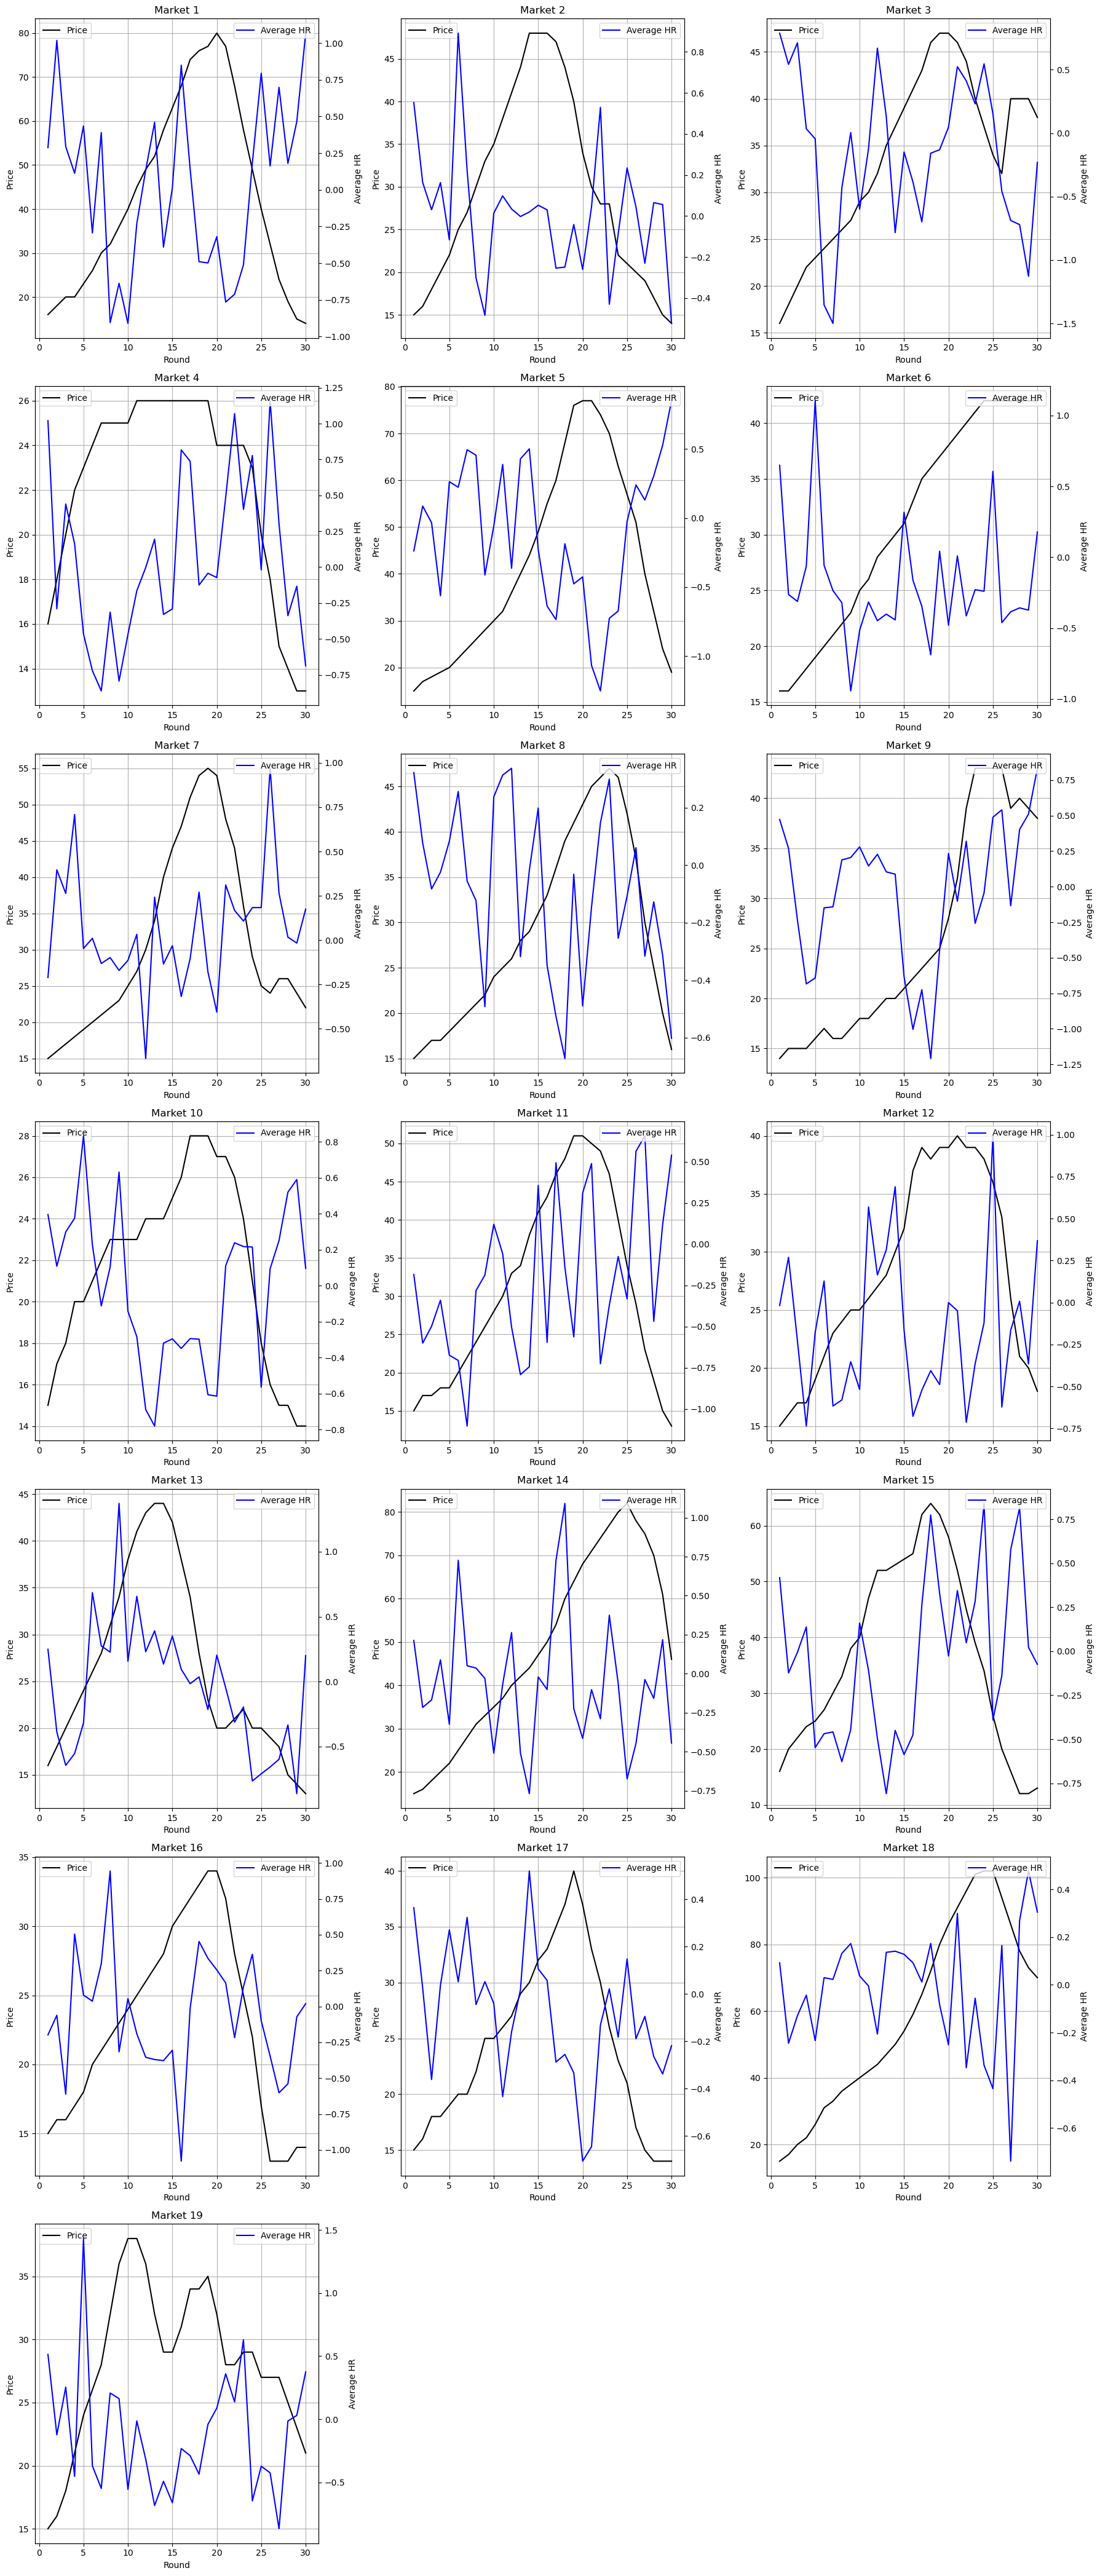

In [29]:
# subplots
sorted_market_ids = sorted(data['market_id'].unique())
num_markets = len(sorted_market_ids)
num_rows = (num_markets + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
axes = axes.flatten()  # flatten to easily iterate over

# plot each market
for i, market in enumerate(sorted_market_ids):
    market_data = avg_bio[avg_bio['market_id'] == market]
    price_data = market_prices[market_prices['market_id'] == market]
    
    ax = axes[i]
    ax.plot(price_data['round'], price_data['price'], color='black', label='Price')
    ax.set_xlabel('Round')
    ax.set_ylabel('Price')
    ax.set_title(f'Market {market + 1}')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(market_data['round'], market_data['avg_hr'], color='blue', label='Average HR')
    ax2.set_ylabel('Average HR')
    ax2.legend(loc='upper right')

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

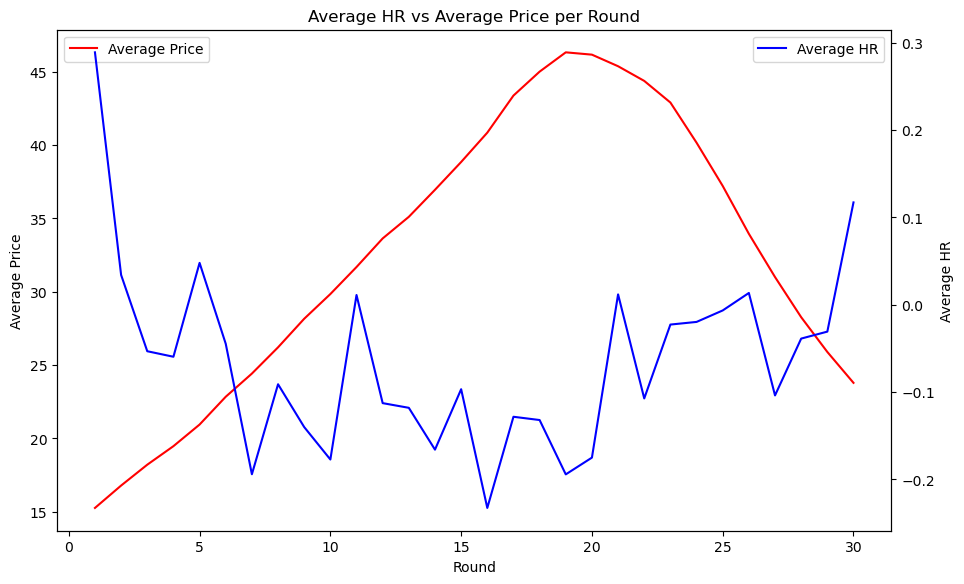

In [30]:
avg_hr_per_round = avg_bio.groupby('round')['avg_hr'].mean().reset_index()
avg_price_per_round = market_prices.groupby('round')['price'].mean().reset_index()
merged_averages = pd.merge(avg_hr_per_round, avg_price_per_round, on='round')

# plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# average price
ax1.set_xlabel('Round')
ax1.set_ylabel('Average Price')
ax1.plot(merged_averages['round'], merged_averages['price'], color='red', label='Average Price')
ax1.tick_params(axis='y')

# average HR
ax2 = ax1.twinx()
ax2.set_ylabel('Average HR')
ax2.plot(merged_averages['round'], merged_averages['avg_hr'], color='blue', label='Average HR')
ax2.tick_params(axis='y')

# legends
fig.tight_layout(pad=2.0)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average HR vs Average Price per Round')
plt.show()

r = -0.10870768312420623


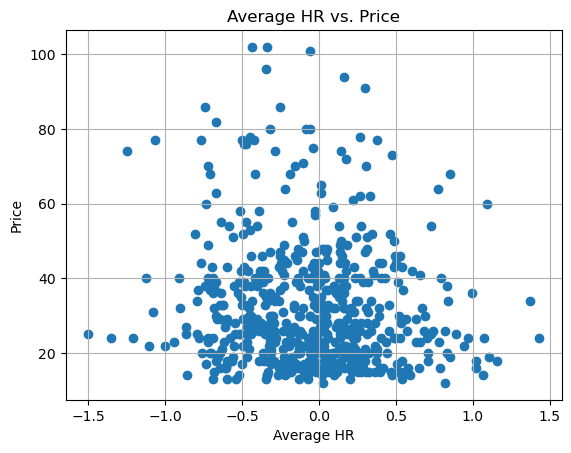

In [31]:
correlation = bio_price_merged['avg_hr'].corr(bio_price_merged['price'])
print(f"r = {correlation}")

x = bio_price_merged['avg_hr']
y = bio_price_merged['price']

plt.scatter(x, y)
plt.xlabel('Average HR')
plt.ylabel('Price')
plt.title('Average HR vs. Price')
plt.grid(True)
plt.show()

### 4.4 Temp vs Price

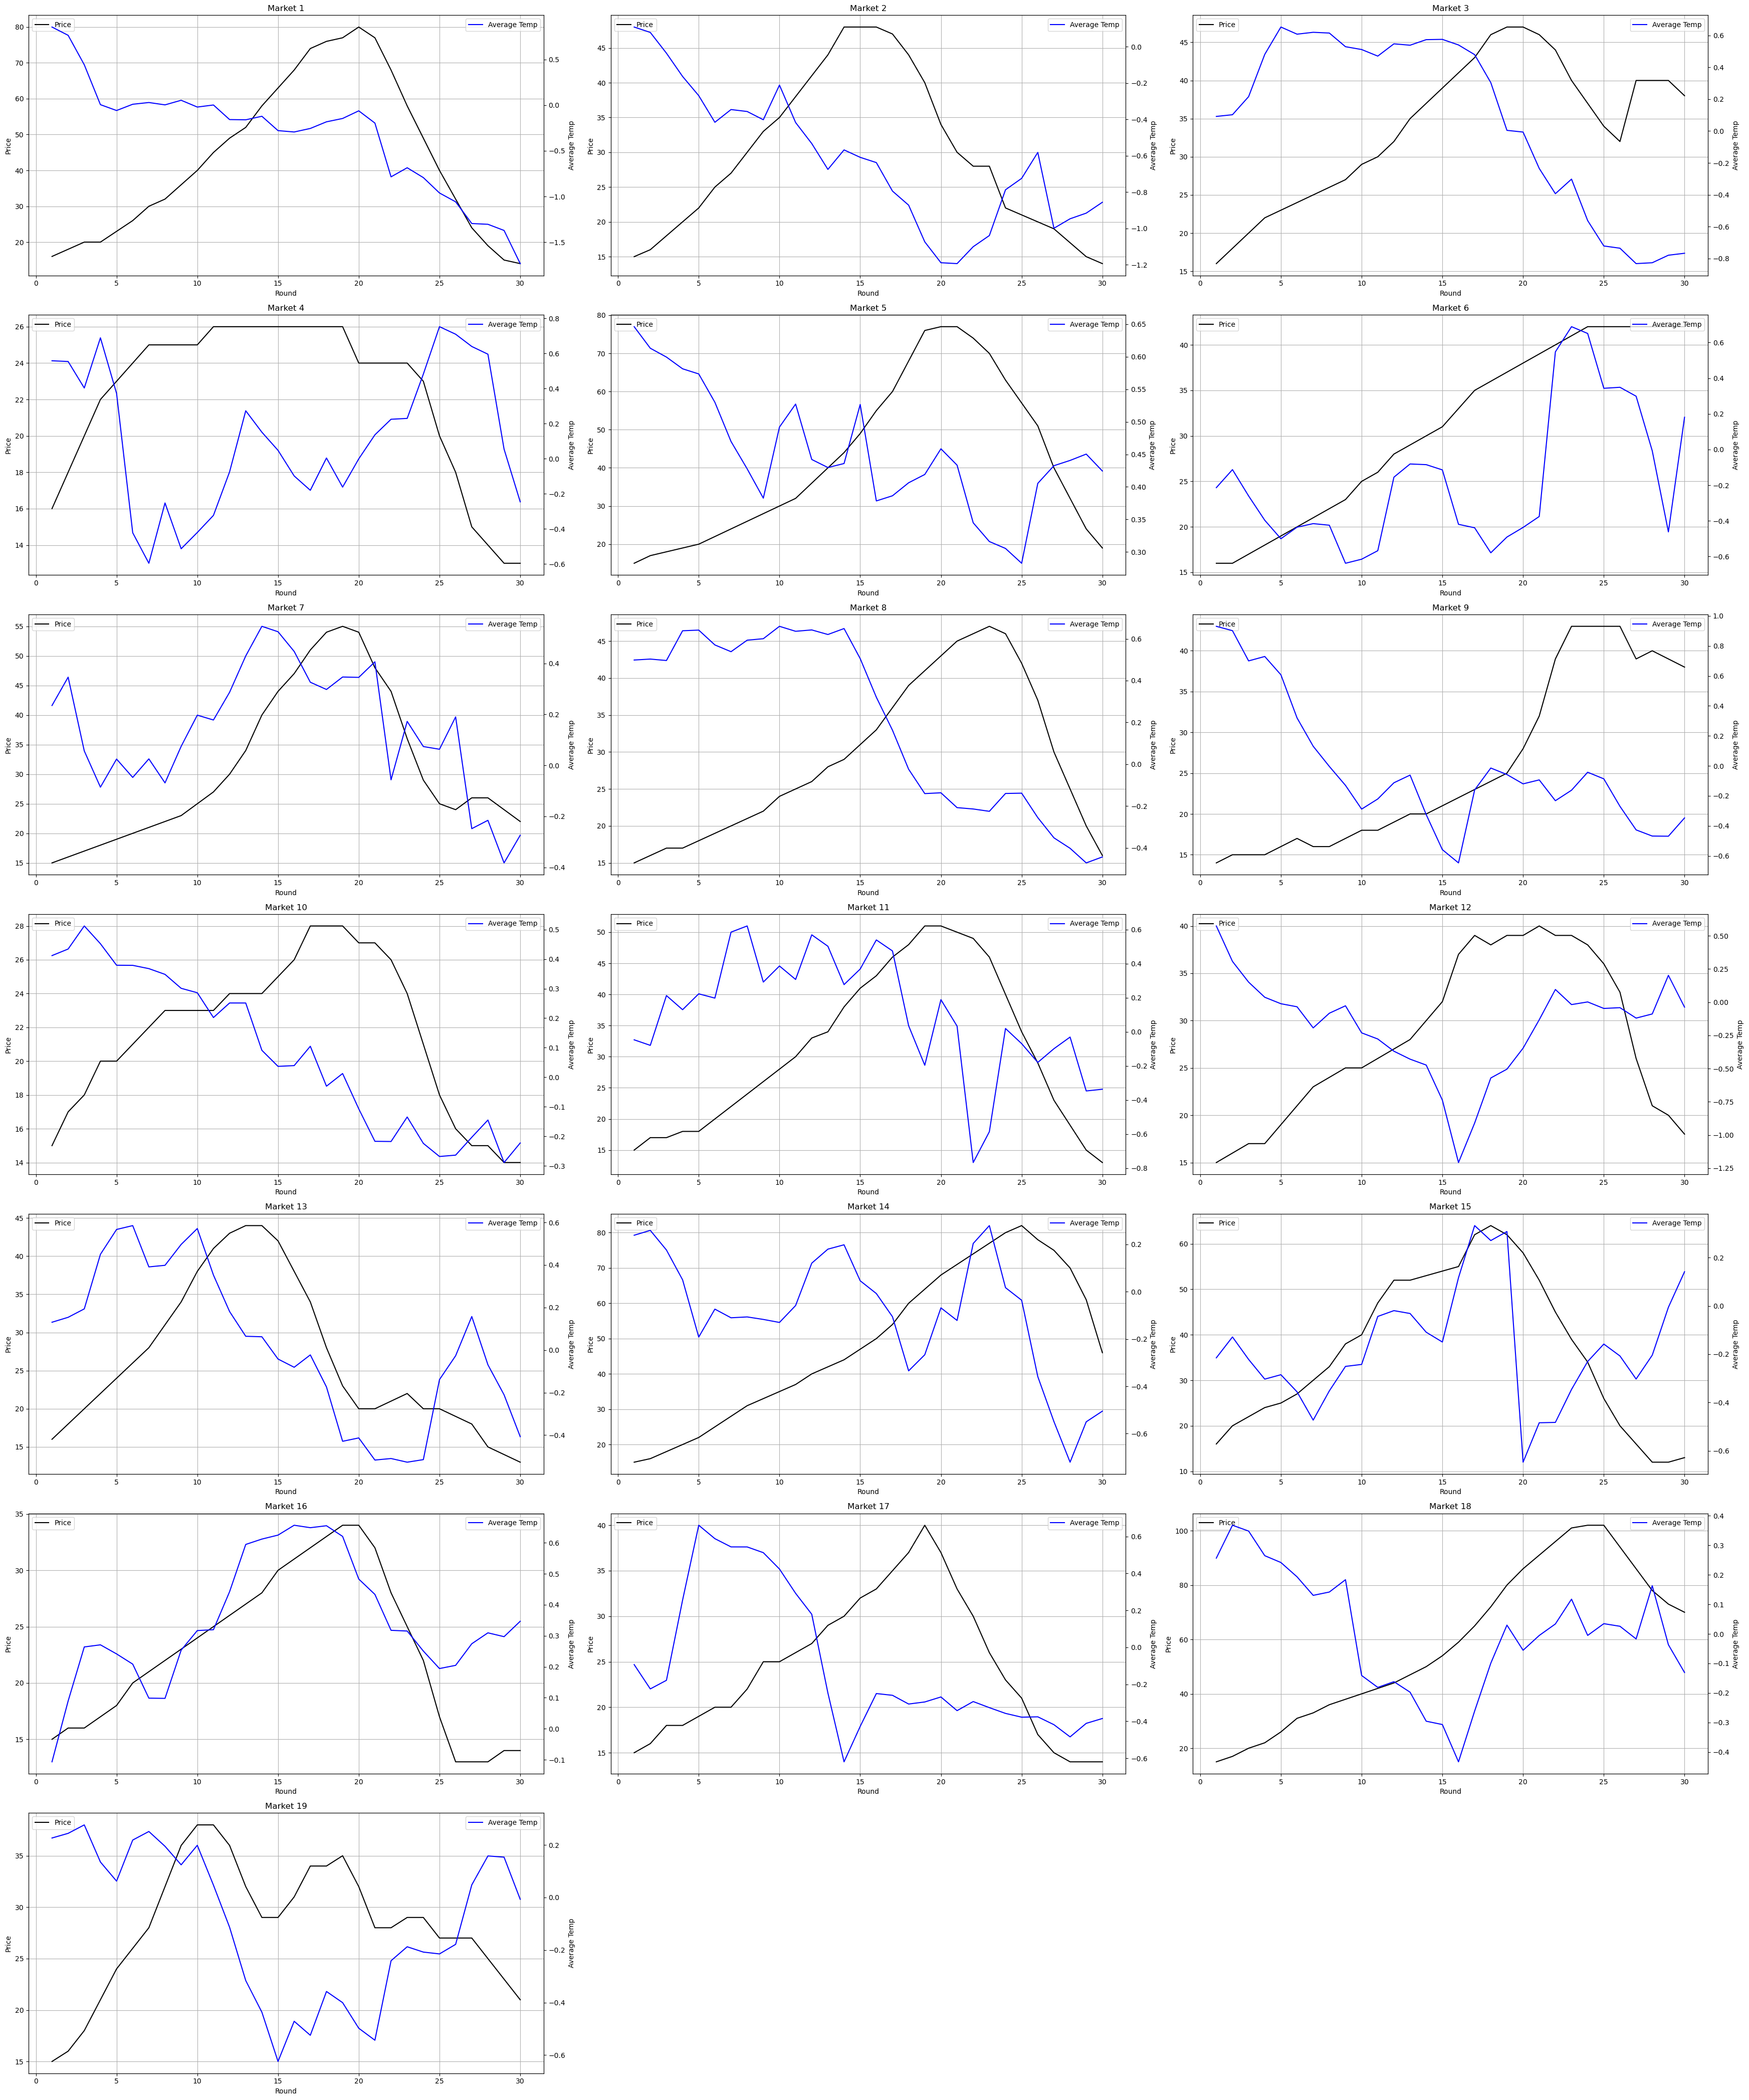

In [32]:
# subplots
sorted_market_ids = sorted(data['market_id'].unique())
num_markets = len(sorted_market_ids)
num_rows = (num_markets + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(35, 6 * num_rows))
axes = axes.flatten()  # flatten to easily iterate over

# plot each market
for i, market in enumerate(sorted_market_ids):
    market_data = avg_bio[avg_bio['market_id'] == market]
    price_data = market_prices[market_prices['market_id'] == market]
    
    ax = axes[i]
    ax.plot(price_data['round'], price_data['price'], color='black', label='Price')
    ax.set_xlabel('Round')
    ax.set_ylabel('Price')
    ax.set_title(f'Market {market + 1}')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(market_data['round'], market_data['avg_temp'], color='blue', label='Average Temp')
    ax2.set_ylabel('Average Temp')
    ax2.legend(loc='upper right')

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

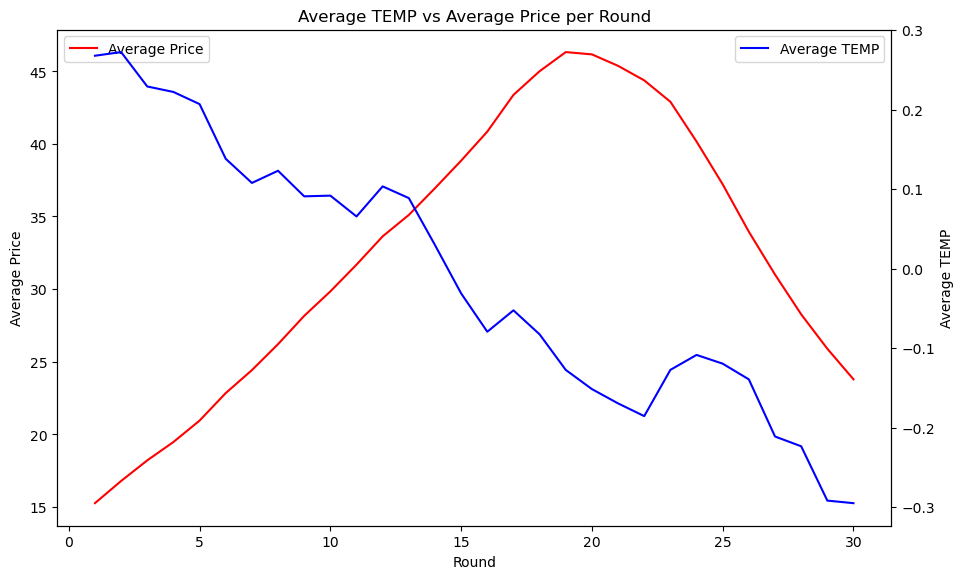

In [44]:
avg_temp_per_round = avg_bio.groupby('round')['avg_temp'].mean().reset_index()
avg_price_per_round = market_prices.groupby('round')['price'].mean().reset_index()
merged_averages = pd.merge(avg_temp_per_round, avg_price_per_round, on='round')

# plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# average price
ax1.set_xlabel('Round')
ax1.set_ylabel('Average Price')
ax1.plot(merged_averages['round'], merged_averages['price'], color='red', label='Average Price')
ax1.tick_params(axis='y')

# average temp
ax2 = ax1.twinx()
ax2.set_ylabel('Average TEMP')
ax2.plot(merged_averages['round'], merged_averages['avg_temp'], color='blue', label='Average TEMP')
ax2.tick_params(axis='y')

# legends
fig.tight_layout(pad=2.0)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average TEMP vs Average Price per Round')
#plt.savefig('/Users/cadyngo/Desktop/AA5.png')
plt.show()

r = -0.08629957044167653


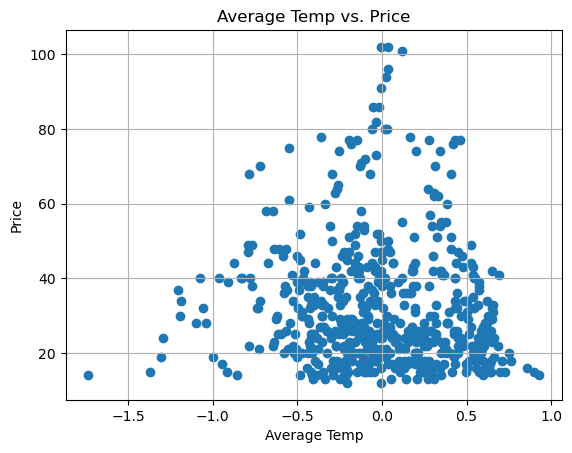

In [34]:
correlation = bio_price_merged['avg_temp'].corr(bio_price_merged['price'])
print(f"r = {correlation}")

x = bio_price_merged['avg_temp']
y = bio_price_merged['price']

plt.scatter(x, y)
plt.xlabel('Average Temp')
plt.ylabel('Price')
plt.title('Average Temp vs. Price')
plt.grid(True)
plt.show()